In [1]:
import sqlalchemy
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import log_loss
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import time
from sklearn.model_selection import train_test_split
from datetime import datetime

## MVP

In [ ]:
# from sqlalchemy import create_engine
# engine = create_engine('postgresql:///walk')

In [ ]:
df = pd.read_sql_table('manhattan_loc_d_ar_wea', 'postgresql:///walk')

In [9]:
def categorize_arrests(dataframe):
    cat_df = dataframe.copy()
    cat_df.loc[cat_df['n_arrests'] > 0] = 1
    cat_df['n_arrests'] = cat_df['n_arrests'].fillna(value=0)
    return cat_df

In [ ]:
last_ten = df.shape[0]*.9
eval_df = df.reset_index(drop=True).loc[last_ten:]
test_train_df = df.reset_index(drop=True).loc[:last_ten]
X_eval = eval_df.drop(columns=['n_arrests'])
y_eval = categorize_arrests(eval_df['n_arrests'])

In [ ]:
X = test_train_df.drop(columns=['n_arrests'])
y = categorize_arrests(test_train_df['n_arrests'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [ ]:
df.head()

In [ ]:
class DateTransformer():
    """Transforms df so that there are columns representing the features of the date.
    """
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.Series([pd.to_datetime(x, format="%Y-%m-%d") for x in X['date']])
        X_transf = pd.DataFrame()
        X_transf['year'] = [x.year for x in X]
        X_transf['month'] = [x.month for x in X]
        X_transf['day'] = [x.day for x in X]
        X_transf['weekday'] = [x.weekday() for x in X]
        return np.array(X_transf)

In [ ]:
class TimeOfDayTransformer():    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        structtime = [time.gmtime(x) for x in X.values]
        X_transf = np.array([(x.tm_hour*60 + x.tm_min) for x in structtime]).reshape(-1, 1)
        return X_transf

In [ ]:
class StringTransformer():    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
#         X_trans = np.array(X.astype(str)).reshape(-1, 1)
#         print(X_trans)
        return np.array(X.astype(str)).reshape(-1, 2)

In [ ]:
impute_zero_features = ['precip_accum100']
impute_zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# impute_mean_features = ['ozone10']
# impute_mean_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer()),
#     ('scaler', StandardScaler())
# ])

date_transformer = Pipeline(steps=[
    ('date_expansion', DateTransformer()),
    ('ohe', OneHotEncoder(categories='auto'))
])

# categorical_features = ['icon', 'precipType']
# categorical_transformer = Pipeline(steps=[
#     ('string', StringTransformer()),
#     ('ohe', OneHotEncoder(categories='auto'))
# ])

time_of_day_features = ['sunriseTime', 'sunsetTime']
time_of_day_transformer = Pipeline(steps=[
    ('time', TimeOfDayTransformer()),
    ('scaler', StandardScaler())
])

other_numeric_features = ['latitude', 'longitude', 'ap_t_high100',
                         'ap_t_low100', 'cloud', 'humidity',
                          'precip_inten_max10000', 'precip_proba100', 
                          'wind_gust100',] 
                        # removed: 'moon_phase','pressure','uvIndex', 

preprocessor = ColumnTransformer( transformers=[
    ('missing0', impute_zero_transformer, impute_zero_features),
#     ('missing_mean', impute_mean_transformer, impute_mean_features),
    ('date', date_transformer, ['date']),
#     ('categoricals', categorical_transformer, categorical_features),
    ('sunrise', time_of_day_transformer, ['sunriseTime']),
    ('sunset', time_of_day_transformer, ['sunsetTime']),
    ('ss', StandardScaler(), other_numeric_features)
    ], remainder='passthrough')




In [ ]:
rfc = RandomForestClassifier(n_estimators=10, max_depth=15, random_state=5,
                            class_weight='balanced')
# sm = SMOTE(random_state=20)

In [ ]:
pipe = Pipeline([
    ('preprocess', preprocessor),
#     ('smote', sm),
    ('model', rfc)
])

In [ ]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
train_preds = pipe.predict(X_train)
train_proba = pipe.predict_proba(X_train)

In [ ]:
print_scores(y_train, train_preds, train_proba)

In [ ]:
test_preds = pipe.predict(X_test)
test_proba = pipe.predict_proba(X_test)

In [ ]:
print_scores(y_test, test_preds, test_proba)

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
test_proba[:20]

In [ ]:
fig, ax = plt.subplots()
ax.hist(test_proba[:,0], bins=20)
ax.tick_params(axis='x', colors='white')

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fpr, tpr, thrsholds = roc_curve(y_test, test_proba[:, 1])

In [ ]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white');

In [ ]:
pipe.named_steps['preprocess']

In [ ]:
plt.barh(range(rfc.n_features_), rfc.feature_importances_)

In [ ]:
for estimator in rfc.estimators_:
    print (estimator.tree_.node_count)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(random_state=0, solver='lbfgs')

In [ ]:
lr_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', rfc)
])

In [ ]:
lr_

In [ ]:
import pickle

In [ ]:
output_file = open("walk1.pickle", "wb")
pickle.dump(rfc, output_file)
output_file.close()

In [29]:
from joblib import dump, load

In [ ]:
output_file = open("preprocessor.joblib", "wb")
dump(preprocessor, output_file)
output_file.close()

In [27]:
import pickle
import pandas as pd
import joblib

In [ ]:
model_file = open('walk1.pickle', "rb")
loaded_model = pickle.load(model_file)
model_file.close()

In [ ]:
preprocessor_file = open('preprocessor.joblib', 'rb')
loaded_preprocessor = joblib.load(preprocessor_file)
preprocessor_file.close()

In [ ]:
# path, warnings = get_route(secret_loc_goog, start_lat_long, end_lat_long)

pts = pd.read_csv('practice_route_pts.csv') # pts = get_points_near_path(path, )
pts = pts.drop(columns=['geometry', 'on_path'])

In [ ]:
df.columns

In [ ]:
day_weather = pd.DataFrame(df.loc[0, 'date':'precip_accum100']).T

In [ ]:
day_weather.head()

In [ ]:
day_weather = day_weather.drop(columns=['n_arrests'])
day_weather.columns

In [ ]:
for col in day_weather.columns:

    pts[col] = day_weather[col].values[0]

In [ ]:
pts.head()

In [ ]:
pts.columns

In [ ]:
inputs = loaded_preprocessor.transform(pts)

In [ ]:
preds = loaded_model.predict_proba(inputs)

In [ ]:
arr_proba = [x[1] for x in preds]

In [ ]:
sum(arr_proba)/24

In [ ]:
arr_proba

In [ ]:
for estimator in loaded_model.estimators_:
    print (estimator.tree_.node_count)

In [ ]:
loaded_model.feature_importances_

# Minimum MVP

In [ ]:
def predict_arrest_proba(start, end):
    return y.mean()

In [ ]:
round(predict_arrest_proba("",""), 3)

In [ ]:
round(y_eval.mean(), 3)

# 2nd MVP

In [ ]:
import pandas as pd

In [ ]:
lat_long_arrests_df = pd.read_sql_query("""
                    SELECT latitude, 
                            longitude, 
                            COUNT(n_arrests) as arrest_days 
                    FROM manhattan_loc_d_ar_wea 
                    GROUP BY latitude, longitude;"""
                                    , 'postgresql:///walk')

final_date = pd.read_sql_query("""SELECT date
                                    FROM manhattan_loc_d_ar_wea
                                    ORDER BY date DESC
                                    LIMIT 1""", 'postgresql:///walk')

start_date = pd.read_sql_query("""SELECT date
                                    FROM manhattan_loc_d_ar_wea
                                    ORDER BY date ASC
                                    LIMIT 1""", 'postgresql:///walk')

total_days = (final_date.iloc[0,0] - start_date.iloc[0,0]).days

# set probability for each location based on the rate of days with arrests in the data set
lat_long_arrest_df['probability'] = lat_long_arrest_df['arrest_days'] / total_days

# create latlong column as unique identifier to join on
pts_df['latlong'] = (round(pts_df['latitude'], 3).astype(str) 
                     + round(pts_df['longitude'], 3).astype(str))
lat_long_arrest_df['latlong'] = (round(lat_long_arrest_df['latitude'], 3).astype(str) 
                              + round(lat_long_arrest_df['longitude'], 3).astype(str))

# clean lat_long_est_df
lat_long_arrest_df = lat_long_arrest_df.drop(columns=['latitude', 'longitude'])

# left join data tables on 'latlong', adding the probability of arrest occuring to each latlong in pts_df
pts_proba_df = pts_df.set_index('latlong').join(lat_long_arrest_df.set_index('latlong'))


# 3rd MVP

In [4]:
df = pd.read_sql_query("""
                                        SELECT latitude, 
                                                longitude, 
                                                ap_t_high100, 
                                                n_arrests
                                        FROM manhattan_loc_d_ar_wea 
                                        ;"""
                                    , 'postgresql:///walk')

In [5]:
df = df.fillna(0)

In [6]:
df['latlong'] = df['latitude'].astype(str) + df['longitude'].astype(str)

In [10]:
last_ten = df.shape[0]*.9
eval_df = df.reset_index(drop=True).loc[last_ten:]
test_train_df = df.reset_index(drop=True).loc[:last_ten]
X_eval = eval_df.drop(columns=['n_arrests'])
y_eval = categorize_arrests(eval_df['n_arrests'])

In [11]:
X = test_train_df.drop(columns=['n_arrests'])
y = categorize_arrests(test_train_df['n_arrests'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [13]:
column_transformer = ColumnTransformer( 
    transformers=[
    ('ohe', OneHotEncoder(categories='auto'), ['latlong']),
    ('ss', StandardScaler(), ['latitude', 'longitude', 'ap_t_high100'])],
    remainder='drop')

In [14]:
transformed = column_transformer.fit_transform(X_train)
transformed[0:5]

<5x6315 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [16]:
rfc = RandomForestClassifier(n_estimators=10, random_state=5, max_depth=10,
                            class_weight='balanced')

In [17]:
pipe = Pipeline([
    ('preprocessor', column_transformer),
    ('model', rfc)
])

In [18]:
stamp_time()
pipe.fit(X_train, y_train)
stamp_time()

Current Time = 18:16:35
Current Time = 18:16:57


In [19]:
train_preds = pipe.predict(X_train)
train_proba = pipe.predict_proba(X_train)
print_scores(y_train, train_preds, train_proba)

log loss: 0.6755737136737081

confusion matrix:
[[2417622   15312]
 [  34414    9481]]
accuracy: 0.9799235231822625
F1 score: 0.2760598648963429


In [20]:
test_preds = pipe.predict(X_test)
test_proba = pipe.predict_proba(X_test)
print_scores(y_test, test_preds, test_proba)

log loss: 0.6756658178293719

confusion matrix:
[[604261   3925]
 [  8722   2300]]
accuracy: 0.9795755222800739
F1 score: 0.26671305154519626


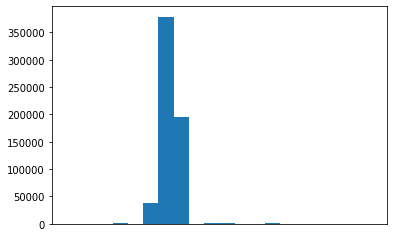

In [24]:
fig, ax = plt.subplots()
ax.hist(test_proba[:,1], bins=20)
ax.tick_params(axis='x', colors='white')

<BarContainer object of 6315 artists>

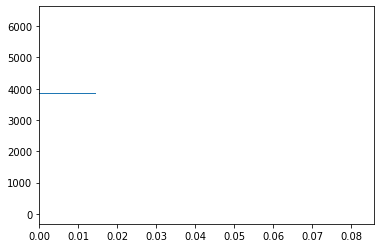

In [25]:
plt.barh(range(rfc.n_features_), rfc.feature_importances_)

In [26]:
for estimator in rfc.estimators_:
    print (estimator.tree_.node_count)

231
231
237
313
329
309
285
243
247
309


NameError: name 'preprocessor' is not defined

In [1]:
from datetime import datetime
from sklearn.metrics import (log_loss, confusion_matrix, accuracy_score, 
                            f1_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sqlalchemy import create_engine
import pandas as pd

In [2]:
def categorize_arrests(dataframe):
    cat_df = pd.DataFrame(dataframe, columns=['n_arrests'])
    cat_df.loc[cat_df['n_arrests'] > 0] = 1
    cat_df = cat_df.fillna(value=0)
    return cat_df

In [4]:
    df = pd.read_sql_query("""
                        SELECT latitude, 
                                longitude, 
                                ap_t_high100, 
                                n_arrests
                        FROM manhattan_loc_d_ar_wea 
                        ;"""
                        , 'postgresql:///walk')
    categorized_df = categorize_arrests(df)

    # add combined lat/long location feature
    categorized_df['latlong'] = (categorized_df['latitude'].astype(str) 
                                + categorized_df['longitude'].astype(str))
    X_train, y_train, X_eval, y_eval = split_last(categorized_df)

KeyError: 'latitude'

In [5]:
df.head()

,latitude,longitude,ap_t_high100,n_arrests
0,40.683,-74.023,1943,NaN
1,40.684,-74.012,1943,NaN
2,40.684,-74.024,1943,NaN
3,40.685,-74.022,1943,NaN
4,40.685,-74.023,1943,NaN


In [6]:
def split_last(dataframe, sort_col='date', cut=.9):
    if sort_col != None:
        dataframe = dataframe.sort_values(by=sort_col, axis='columns')
    cutoff = dataframe.shape[0]*cut
    first_df = dataframe.reset_index(drop=True).loc[:cutoff]
    last_df = dataframe.reset_index(drop=True).loc[cutoff:]
    X_train = first_df.drop(columns=['n_arrests'])
    y_train = first_df['n_arrests']
    X_eval = last_df.drop(columns=['n_arrests'])
    y_eval = last_df['n_arrests']
    return X_train, y_train, X_eval, y_eval

In [10]:
df = pd.read_sql_query("""
                        SELECT latitude, 
                                longitude, 
                                ap_t_high100, 
                                n_arrests
                        FROM manhattan_loc_d_ar_wea 
                        ;"""
                        , 'postgresql:///walk')
categorized_df = categorize_arrests(df)

# add combined lat/long location feature
categorized_df['latlong'] = (categorized_df['latitude'].astype(str) 
                            + categorized_df['longitude'].astype(str))
X_train, y_train, X_eval, y_eval = split_last(categorized_df, sort_col=None)

In [11]:
X_train.head()

,latitude,longitude,ap_t_high100,latlong
0,40.683,-74.023,1943,40.683-74.023
1,40.684,-74.012,1943,40.684-74.012
2,40.684,-74.024,1943,40.684-74.024
3,40.685,-74.022,1943,40.685-74.022
4,40.685,-74.023,1943,40.685-74.023


In [12]:
X_eval.head()

,latitude,longitude,ap_t_high100,latlong
3096036,40.776,-73.962,6793,40.776-73.962
3096037,40.776,-73.963,6793,40.776-73.963
3096038,40.776,-73.964,6793,40.776-73.964
3096039,40.776,-73.965,6793,40.776-73.965
3096040,40.776,-73.966,6793,40.776-73.966


In [3]:
import pandas as pd

In [12]:
from predict import get_arrest_probas
%load_ext autoreload
%autoreload 2

In [1]:
from results import get_backend_results

In [4]:
pts = pd.read_csv('archive/practice_route_pts.csv')

In [7]:
day_weather_df = pd.DataFrame([3000], columns=['ap_t_high100'])

In [15]:
probas = get_arrest_probas(pts, day_weather_df)

    latitude  longitude        latlong  ap_t_high100
0     40.722    -73.993  40.722-73.993          3000
1     40.722    -73.992  40.722-73.992          3000
2     40.722    -73.991  40.722-73.991          3000
3     40.722    -73.990   40.722-73.99          3000
4     40.722    -73.989  40.722-73.989          3000
5     40.723    -73.995  40.723-73.995          3000
6     40.723    -73.994  40.723-73.994          3000
7     40.723    -73.993  40.723-73.993          3000
8     40.723    -73.992  40.723-73.992          3000
9     40.723    -73.991  40.723-73.991          3000
10    40.723    -73.990   40.723-73.99          3000
11    40.723    -73.989  40.723-73.989          3000
12    40.723    -73.988  40.723-73.988          3000
13    40.724    -73.995  40.724-73.995          3000
14    40.724    -73.994  40.724-73.994          3000
15    40.724    -73.993  40.724-73.993          3000
16    40.724    -73.992  40.724-73.992          3000
17    40.724    -73.991  40.724-73.991        

In [16]:
probas

array([[0.41351199, 0.58648801],
       [0.41351199, 0.58648801],
       [0.41351199, 0.58648801],
       [0.41351199, 0.58648801],
       [0.41351199, 0.58648801],
       [0.48255915, 0.51744085],
       [0.50548208, 0.49451792],
       [0.41351199, 0.58648801],
       [0.41351199, 0.58648801],
       [0.43498811, 0.56501189],
       [0.41351199, 0.58648801],
       [0.41351199, 0.58648801],
       [0.41351199, 0.58648801],
       [0.48255915, 0.51744085],
       [0.48157093, 0.51842907],
       [0.4788015 , 0.5211985 ],
       [0.4788015 , 0.5211985 ],
       [0.4788015 , 0.5211985 ],
       [0.4788015 , 0.5211985 ],
       [0.4788015 , 0.5211985 ],
       [0.49741508, 0.50258492],
       [0.48437589, 0.51562411],
       [0.44486317, 0.55513683],
       [0.4788015 , 0.5211985 ],
       [0.4788015 , 0.5211985 ],
       [0.4788015 , 0.5211985 ],
       [0.4788015 , 0.5211985 ],
       [0.4788015 , 0.5211985 ],
       [0.5019826 , 0.4980174 ],
       [0.4788015 , 0.5211985 ],
       [0.

## Get colors for key

In [21]:
from matplotlib import pyplot as plt
import matplotlib as mpl

In [23]:
for index in range(0, 11):
    index /= 10
    color = plt.cm.Reds(index)
    color = mpl.colors.to_hex(color)
    print(color)

#fff5f0
#fee5d8
#fdcab5
#fcab8f
#fc8a6a
#fb694a
#f14432
#d92523
#bc141a
#980c13
#67000d
